In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn import metrics
%matplotlib inline

### Knn Model

In [2]:
# Read data
train_df = pd.read_csv("train_data.csv", index_col = 0)
val_df = pd.read_csv("validation_data.csv", index_col = 0)
train_validation_df = pd.read_csv("train_validation_data.csv", index_col = 0)
test_df = pd.read_csv("test_data.csv", index_col = 0)

X_train = train_df.drop('shares', 1)
Y_train = train_df['shares']
X_val = val_df.drop('shares', 1)
Y_val = val_df['shares']

In [4]:
# Function to return auc
def Knn_auc(k, X_train, Y_train, X_val, Y_val, p):
    neigh = KNeighborsClassifier(n_neighbors = k, p = p)
    neigh.fit(X_train, Y_train)
    preds_knn = neigh.predict_proba(X_val)[:,1]
    knn_fpr, knn_tpr, knn_thresholds = roc_curve(Y_val, preds_knn)
    knn_roc_auc = auc(knn_fpr, knn_tpr)
    return knn_roc_auc

In [5]:
# Function to return tpr
def Knn_tpr(k, X_train, Y_train, X_val, Y_val, p):
    neigh = KNeighborsClassifier(n_neighbors = k, p = p)
    neigh.fit(X_train, Y_train)
    true_positive = confusion_matrix(Y_val, neigh.predict(X_val))[1][1]
    false_negative = confusion_matrix(Y_val, neigh.predict(X_val))[1][0]
    tpr = true_positive/(true_positive+false_negative)
    return tpr

Best accuracy for Knn (k = 38) using manhattan_distance: 62.934417040358746%
Best accuracy for Knn (k = 38) using euclidean_distance: 60.73430493273543%


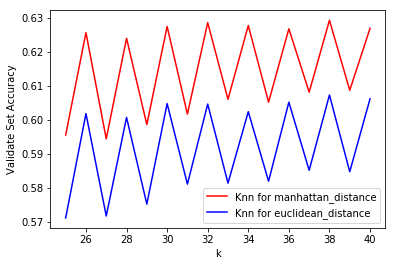

In [6]:
# Visualization of accuracy
s1 = [Knn_acc(i, X_train, Y_train, X_val, Y_val, 1) for i in range(25, 41)]
s2 = [Knn_acc(i, X_train, Y_train, X_val, Y_val, 2) for i in range(25, 41)]

plt.plot(range(25, 41), s1, 'r-', label = "Knn for manhattan_distance")
plt.plot(range(25, 41), s2, 'b-', label = "Knn for euclidean_distance")
plt.legend(loc='best')
plt.xlabel("k")
plt.ylabel("Validate Set Accuracy")

x = [i for i in range(25,41)]
print("Best accuracy for Knn (k = {}) using manhattan_distance: {}%".format(x[np.argsort(s1)[-1]], 100*np.sort(s1)[-1]))
print("Best accuracy for Knn (k = {}) using euclidean_distance: {}%".format(x[np.argsort(s2)[-1]], 100*np.sort(s2)[-1]))

In [18]:
s3 = [Knn_auc(i, X_train, Y_train, X_val, Y_val, 1) for i in range(1,15)]
x = [i for i in range(1,25)]
print("Best auc for k = {}: {}".format(x[np.argsort(s3)[-1]], np.max(s3)))
best_k = x[np.argsort(s3)[-1]]

Best auc for k = 9: 0.582919271555538


In [19]:
s4 = [Knn_tpr(i, X_train, Y_train, X_val, Y_val, 1) for i in range(1,15)]
x = [i for i in range(1,25)]
print("Best tpr for k = {}: {}%".format(x[np.argsort(s4)[-1]], 100*np.max(s4)))
best_ktpr = x[np.argsort(s4)[-1]]

Best tpr for k = 3: 53.43554798409994%


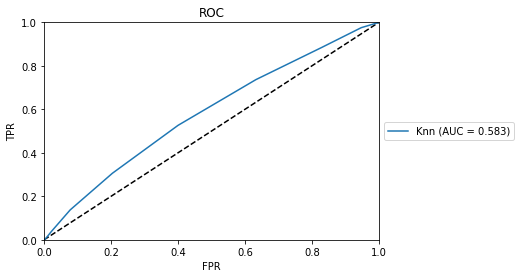

train accuracy: 66.10650069156293 %
test accuracy: 58.169843049327355 %


In [10]:
# Visualization of ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')

knn_model = KNeighborsClassifier(n_neighbors = best_k, p = 1)
knn_model.fit(X_train, Y_train)
preds_knn = knn_model.predict_proba(X_val)[:,1]
knn_fpr, knn_tpr, knn_thresholds = roc_curve(Y_val, preds_knn)
knn_roc_auc = auc(knn_fpr, knn_tpr)
knn_curve = plt.plot(knn_fpr, knn_tpr, label = 'Knn' + ' (AUC = %0.3f)' % knn_roc_auc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

train_predict = knn_model.predict(X_train)
print("train accuracy: {} %".format(100 - np.mean(np.abs(train_predict - Y_train)) * 100))
val_predict = knn_model.predict(X_val)
print("test accuracy: {} %".format(100 - np.mean(np.abs(val_predict - Y_val)) * 100))

### Decision Tree

In [3]:
# Function to return auc
def DT_auc(depth, leaf, X_train, Y_train, X_val, Y_val):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth = depth, min_samples_leaf = leaf)
    dt.fit(X_train, Y_train)
    
    preds_dt = dt.predict_proba(X_val)[:,1]
    dt_fpr, dt_tpr, dt_thresholds = roc_curve(Y_val, preds_dt)
    dt_roc_auc = metrics.auc(dt_fpr, dt_tpr)
    return dt_roc_auc

In [4]:
# Function to return tpr
def DT_tpr(depth, leaf, X_train, Y_train, X_val, Y_val):
    dt = DecisionTreeClassifier(criterion='entropy', max_depth = depth, min_samples_leaf = leaf)
    dt.fit(X_train, Y_train)
    
    true_positive = confusion_matrix(Y_val, dt.predict(X_val))[1][1]
    false_negative = confusion_matrix(Y_val, dt.predict(X_val))[1][0]
    tpr = true_positive/(true_positive+false_negative)
    return tpr

In [5]:
# Get best accuracy of validation set
aucs = {}; tprs = {}
max_depth = [100,150,200,300,500,800]
min_samples_leaf = [5,10,20,50,100,300,500,1000]

for depth in max_depth:
    for leaf in min_samples_leaf:
        auc_value = DT_auc(depth, leaf, X_train, Y_train, X_val, Y_val)
        aucs[(depth, leaf)] = auc_value
        tpr = DT_tpr(depth, leaf, X_train, Y_train, X_val, Y_val)
        tprs[(depth, leaf)] = tpr
        
sort_list1 = sorted(aucs.items(), key=lambda item: (item[1], item[0]))
best_depth1 = sort_list1[-1][0][0]
best_leaf1 = sort_list1[-1][0][1]

sort_list2 = sorted(tprs.items(), key=lambda item: (item[1], item[0]))
best_depth2 = sort_list2[-1][0][0]
best_leaf2 = sort_list2[-1][0][1]

print("Best auc for DT (depth = {0}, leaf = {1}): {2}".format(best_depth1, best_leaf1, sort_list1[-1][-1]))
print("Best tpr for DT (depth = {0}, leaf = {1}): {2}%".format(best_depth2, best_leaf2, 100*sort_list2[-1][-1]))

Best auc for DT (depth = 800, leaf = 300): 0.6582019993541122
Best tpr for DT (depth = 800, leaf = 300): 64.04185022026432%


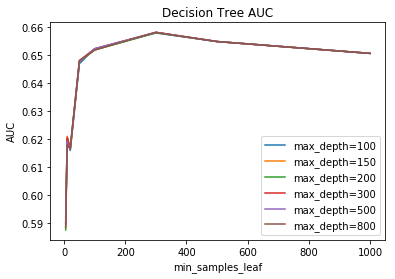

In [9]:
# draw plots for auc and tpr based on hyperparameter choices
for d in max_depth:
        auc_plot_index=max_depth.index(d)
        plt.plot(min_samples_leaf,list(aucs.values())[auc_plot_index*8:(auc_plot_index+1)*8],label='max_depth='+str(d))
        
plt.title('Decision Tree AUC')
plt.xlabel('min_samples_leaf')
plt.ylabel('AUC')
plt.legend()

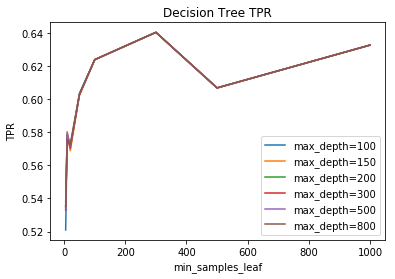

In [11]:
for d in max_depth:
        tpr_plot_index=max_depth.index(d)
        plt.plot(min_samples_leaf,list(tprs.values())[tpr_plot_index*8:(tpr_plot_index+1)*8],label='max_depth='+str(d))
        
plt.title('Decision Tree TPR')
plt.xlabel('min_samples_leaf')
plt.ylabel('TPR')
plt.legend()

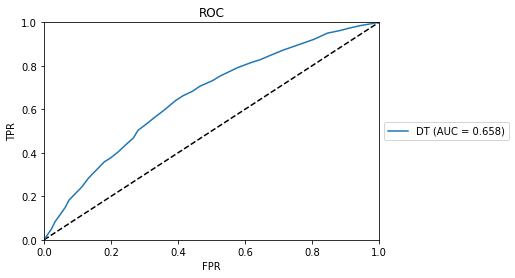

train accuracy: 64.73867595818815 %
test accuracy: 61.561098654708516 %


In [6]:
# Visualization of ROC
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')


dt = DecisionTreeClassifier(criterion='entropy', max_depth = best_depth1, min_samples_leaf = best_leaf1)
dt.fit(X_train, Y_train)
preds_dt = dt.predict_proba(X_val)[:,1]
dt_fpr, dt_tpr, dt_thresholds = roc_curve(Y_val, preds_dt)
dt_roc_auc = auc(dt_fpr, dt_tpr)
dt_curve = plt.plot(dt_fpr, dt_tpr, label = 'DT' + ' (AUC = %0.3f)' % dt_roc_auc)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

train_predict = dt.predict(X_train)
print("train accuracy: {} %".format(100 - np.mean(np.abs(train_predict - Y_train)) * 100))
val_predict = dt.predict(X_val)
print("test accuracy: {} %".format(100 - np.mean(np.abs(val_predict - Y_val)) * 100))

Text(0,0.5,'Normalized Gini Importance')

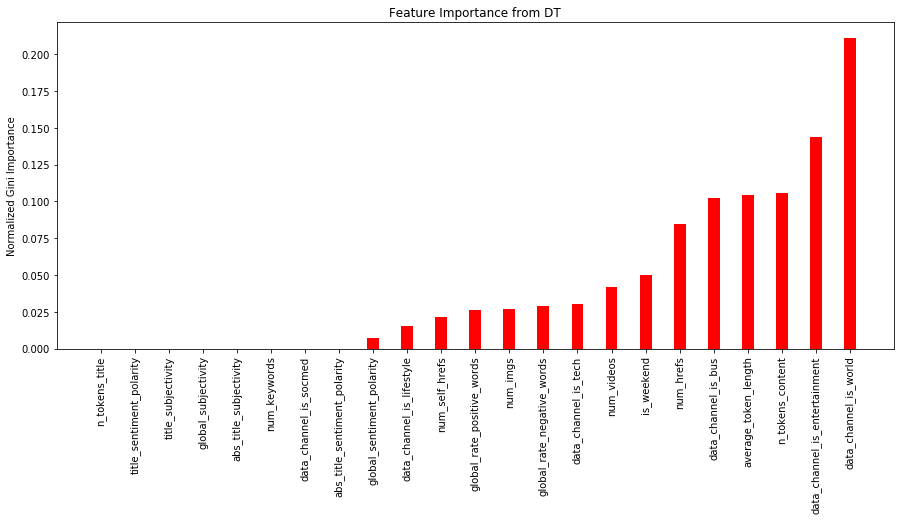

In [27]:
fig, ax = plt.subplots(figsize=(15, 6))
width = 0.35

feature_table = pd.Series(dt.feature_importances_, index = X_train.columns.values).sort_values()
ax.bar(np.arange(len(X_train.columns.values)), feature_table.values, width, color = 'r')
ax.set_xticks(np.arange(len(dt.feature_importances_)))
ax.set_xticklabels(feature_table.index, rotation = 90)
plt.title('Feature Importance from DT')
ax.set_ylabel('Normalized Gini Importance')

### Final Test

In [7]:
test_df.head()

,n_unique_tokens,data_channel_is_entertainment,kw_max_max,kw_avg_max,kw_min_avg,kw_max_avg,kw_avg_avg,self_reference_avg_sharess,is_weekend,LDA_00,LDA_04,min_positive_polarity,shares
0,0.775000,0.0,690400.0,373985.714286,0.000000,5609.470803,3405.119753,9200.00,0.0,0.028573,0.028876,0.1,0
1,0.560209,0.0,843300.0,217880.000000,2181.377520,4094.400000,2877.069049,1080.75,0.0,0.040001,0.040003,0.1,0
2,0.472089,1.0,843300.0,148855.555556,1288.333333,3535.055510,2672.635051,8440.00,0.0,0.022244,0.022477,0.1,0
3,0.663121,1.0,843300.0,584475.000000,2648.578344,5137.787521,3509.865901,0.00,0.0,0.050003,0.050000,0.1,0
4,0.683824,0.0,843300.0,443711.111111,1494.333333,7459.884467,4529.563827,1400.00,0.0,0.022223,0.022222,0.5,0


In [8]:
# For Decision Tree model:
print("DT with best auc:")
print("AUC: {}".format(DT_auc(best_depth1, best_leaf1, train_validation_df.drop('shares',1), train_validation_df['shares'], 
                                                          test_df.drop('shares',1), test_df['shares'])))
print("TPR: {}".format(DT_tpr(best_depth1, best_leaf1, train_validation_df.drop('shares',1), train_validation_df['shares'], 
                                test_df.drop('shares',1), test_df['shares'])))

print("DT with best tpr:")
print("AUC: {}".format(DT_auc(best_depth2, best_leaf2, train_validation_df.drop('shares',1), train_validation_df['shares'], 
                                                          test_df.drop('shares',1), test_df['shares'])))
print("TPR: {}".format(DT_tpr(best_depth2, best_leaf2, train_validation_df.drop('shares',1), train_validation_df['shares'], 
                                test_df.drop('shares',1), test_df['shares'])))


DT with best auc:
AUC: 0.6868346768886215
TPR: 0.6616616616616616
DT with best tpr:
AUC: 0.6868346768886215
TPR: 0.6616616616616616
